In [5]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [6]:
print('Number of files in the train set: ' + str(len(os.listdir('train'))))
print('Number of files in the test set: ' + str(len(os.listdir('test'))))

Number of files in the train set: 2295
Number of files in the test set: 1531


In [7]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


Image height: 866, image width: 1154


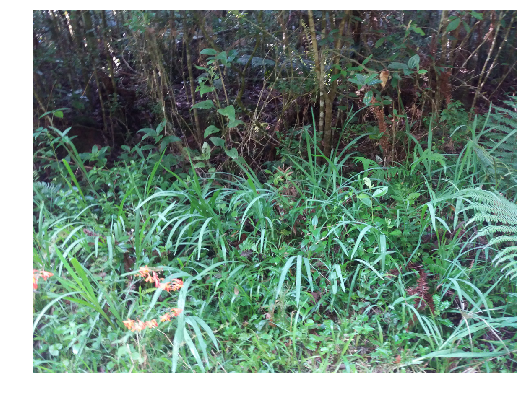

In [8]:
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

# Non-invasive plant image
sample_image = io.imread('train/1.jpg')

print('Image height: {}, image width: {}'.format(*sample_image.shape))

plt.figure(figsize=(8.66, 11.54))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

Image height: 866, image width: 1154


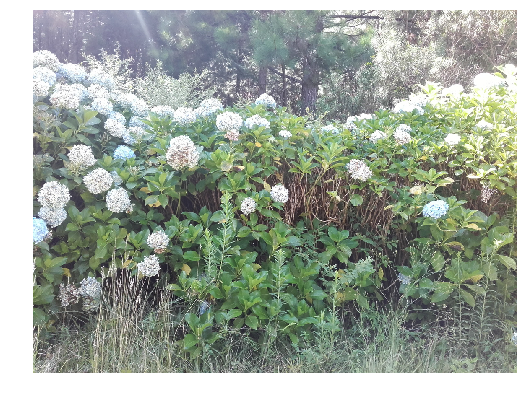

In [9]:
# Invasive plant image
sample_image = io.imread('train/3.jpg')

print('Image height: {}, image width: {}'.format(*sample_image.shape))

plt.figure(figsize=(8.66, 11.54))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

In [10]:
X_train = np.empty(shape=(1500, 150, 200, 3))
y_train = np.array(train_labels.invasive.values[:1500])

X_val = np.empty(shape=(795, 150, 200, 3))
y_val = np.array(train_labels.invasive.values[1500:])

In [11]:
for i in range(1500):
    tr_im = io.imread('train/' + str(i+1) + '.jpg')
    X_train[i] = transform.resize(tr_im, output_shape=(150, 200, 3))

for i in range(795):
    val_im = io.imread('train/' + str(i+796) + '.jpg')
    X_val[i] = transform.resize(val_im, output_shape=(150, 200, 3))

In [16]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 150, 200, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [17]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# model.summary()

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 10

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size, epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint('vgg16.model', monitor='val_acc', save_best_only=True)])

Epoch 1/10
46/46 [==============================] - 759s - loss: 0.2362 - acc: 0.9042 - val_loss: 2.1630 - val_acc: 0.4943

In [20]:
X_test = np.empty(shape=(1531, 150, 200, 3))

for i in range(1531):
    te_im = io.imread('test/' + str(i+1) + '.jpg')
    X_test[i] = transform.resize(te_im, output_shape=(150, 200, 3))

In [21]:
y_pred = model.predict(X_test)

In [22]:
sub = pd.read_csv('sample_submission.csv')
name = sub['name']

output = pd.DataFrame({'name': name, 'invasive': y_pred.ravel()})
output.to_csv('submission.csv', index=False)

In [27]:
output.head()

,invasive,name
0,0.994802,1
1,0.019304,2
2,0.136170,3
3,0.026542,4
4,0.997641,5
